<a href="https://colab.research.google.com/github/E1250/cnn_cv-ref/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Video - https://www.youtube.com/watch?v=FMWun-rx3yo&list=PLyhJeMedQd9TOCgmveCL0debeOQxkP6Vm&index=5
* Gihub code - https://github.com/AhmedIbrahimai/CGAN-in-python-computer-vision

## Conditional GAN

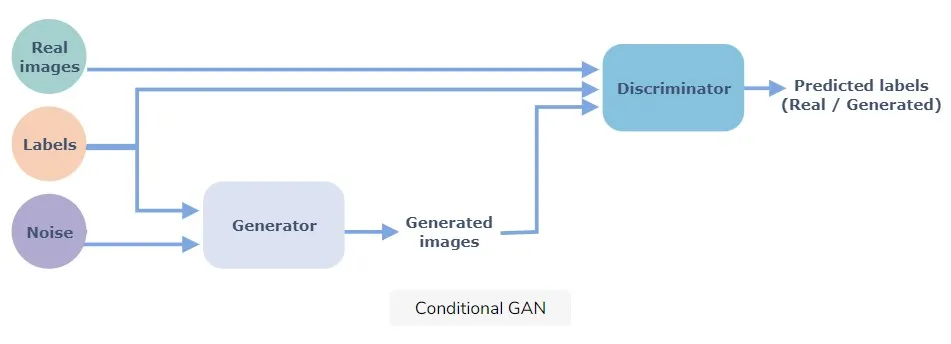

In [1]:
import numpy as np
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 4s 0us/step


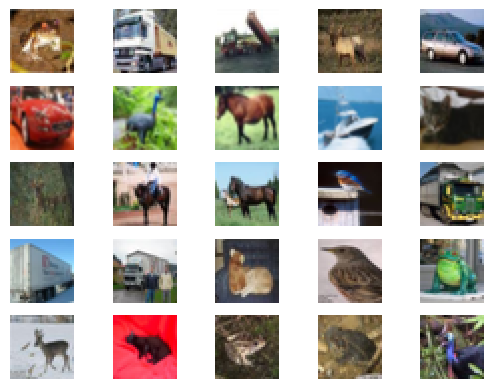

In [2]:
(train_x,train_y),(test_x,test_y) = load_data()
# Plotting the data
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.axis('off')
  plt.imshow(train_x[i])
plt.show()

In [3]:
# Creating the Discriminator
def define_discriminator(in_shape = (32, 32, 3), n_classes = 10):
  # Label Input
  in_label = Input(shape = (1,)) # 1D tensor contain one label value

  # Embedding for categorical input
  # Each label (10 in this dataset), will be represented by a vector of size 50
  # This vector of size 50 will be learnt by the discriminator
  li = Embedding(n_classes, 50)(in_label) # Shape 10 tensor, 50 values, it is converting its input to vector

  # Scale up to image dimentions with linear activation
  n_nodes = in_shape[0] * in_shape[1] # 32 * 32 = 1024.
  li = Dense(n_nodes)(li) # Shape = (1 , 1024)

  # Reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li) # Shape (32 * 32 * 1)

  # Image input
  in_image = Input(shape = in_shape) #   32 * 32 * 3
  # Concat label as a channel
  merge = Concatenate()([in_image, li]) # 32 * 32 * 4 (4 Channels, 3 for image RGB and the 4th for labels)

  # Downsample: this part is the same as UnConditional GAN upto the output layer.
  # We will combine input label with the input image and supply as inputs to the model.
  fe = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(merge) # 16 * 16 * 125
  fe = LeakyReLU(alpha = 0.2)(fe)
  # Downsample
  fe = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(fe) # 8 * 8 * 128
  fe = LeakyReLU(alpha = 0.2)(fe)
  # Flatten features maps
  fe = Flatten()(fe) # 8192 ( 8 * 8 * 128)
  # Dropout
  fe = Dropout(0.4)(fe)
  # Output
  out_layer = Dense(1, activation = 'sigmoid')(fe) # Shape = 1

  # Define model
  ## Combine input label with input image and supply as inputs to the model.
  model = Model([in_image, in_label], out_layer)
  # Compile model
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
  return model

In [4]:
test_discr = define_discriminator()
test_discr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                              

In [5]:
def define_generator(latent_dim, n_classes = 10):
  # Input Label
  in_label = Input(shape = (1,)) # Input of dim 1
  # Embedding for Categorcial Input
  # Each label (total 10 classes for cifar), Will be represented be a vector of size 50.
  li = Embedding(n_classes, 50)(in_label) # Shape (1, 50)

  # Linear multiplication
  n_nodes = 8 * 8 # To match the dimensions for concatenation later in the step.
  li = Dense(n_nodes)(li) # (1, 64)
  # Reshape to additional channel
  li = Reshape((8, 8, 1))(li)

  # Image generator input (noise)
  in_lat = Input(shape = (latent_dim,)) # Input of dim 100

  # Foundation for 8*8 image
  # We will reshape the input latent vector into 8*8 image as a strarting point.
  # So n_nodes for the Dense layer can be 128*8*8 so when we reshape the output.
  # it would be 8*8*128 and that can be slowly upscaled to 32*32 image for output.
  # Note that this part is same as unconditional GAN until the output layer.
  # While defining model imputs we will combine input label and the latent input.
  n_nodes = 128 * 8 * 8
  gen = Dense(n_nodes)(in_lat) # Shape (8192)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Reshape((8,8,128))(gen) # Shape (8*8*125)
  # Merge image gen and label input
  merge = Concatenate()([gen, li]) # Shape (8*8*129) (Extra chennel corresponds to the label)
  # Upsample to 16*16
  gen = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same')(merge) # 16*16*128
  gen = LeakyReLU(alpha = 0.2)(gen)
  # UpSample to 32*32
  gen = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same')(gen) # 32*32*128
  gen = LeakyReLU(alpha = 0.2)(gen)
  # Output
  out_layer = Conv2D(3, (8,8), activation = 'tanh', padding = 'same')(gen) # 32*32*3
  # Define model
  model = Model([in_lat, in_label], out_layer)
  return model # Model not compiled as it is not directly trained like the discriminator.

In [6]:
test_gen = define_generator(100, n_classes = 10)
test_gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                            

In [7]:
def define_gan(g_model, d_model):
  d_model.trainable = False # Descriminator is trained separately, So set to not trainable.

  # Connect generator and Discriminator
  # First, get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input # Latent vector size and label size
  # Get image output from the generator model
  gen_output = g_model.output # 32*32*3

  # Generator image output and corresponding input label are inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # Define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # Compile model
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  return model

In [8]:
# Loading Cifar dataset
def load_real_samples():
  # Load dataset
  (train_x, train_y),(_,_) = load_data()
  # Convert to float
  X = train_x.astype('float32')
  # Scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5 # Cause Generator uses tanh activation so rescale
  # Origianl images to -1 to 1 to match the output of generator.
  return [X, train_y]

In [9]:
d = load_real_samples()
d[0].shape

(50000, 32, 32, 3)

In [10]:
dd, la = load_real_samples()
dd.shape

(50000, 32, 32, 3)

In [11]:
import numpy as np
# Adding the 1 indicating they are real data
def generate_real_samples(dataset, n_samples):
  # Split dataset into images and labels
  images, labels = dataset
  # Choose random instances
  ix = np.random.randint(0, images.shape[0], n_samples)  # range(0, 50000, )
  # Select images and labels
  X, labels = images[ix], labels[ix]
  # Generate class labels and assign to y (don't confus this with the above labels that correspond to cifer labels)
  y = np.ones((n_samples, 1)) # Labels = 1 indicating they are real

  return [X, labels], y

In [12]:
# Generating noise (Generator Input)
def generate_latent_points(latent_dim, n_samples, n_classes = 10):
  # Generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples) # random noise
  # Reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim) # 64 row, 100 col
  # Generate labels
  labels = np.random.randint(0, n_classes, n_samples) # Creating random -labels- for noise data

  return [z_input, labels]

In [13]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # Generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # Predict outputs
  images = generator.predict([z_input, labels_input])
  # Create class labels
  y = np.zeros((n_samples, 1)) # Label = 0 indicating they are fake

  return [images, labels_input], y

### Now Training Step

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 100, n_batches = 128):
  batch_per_epoch = int(dataset[0].shape[0] / n_batches)
  half_batch = int(n_batches / 2)
  # Discriminator model is updated for a half batch of real samples and half batch of fake samples, combiend at a single batch

  # Manully enumerate epochs
  for i in range(n_epochs):
    # Enumerate batches over the training set
    for j in range(batch_per_epoch):
      # Train the discriminator on real and fake images, separately(half batch each)
      # Research showed that separate training is more effective.
      # Get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      # Update Discriminator model weights
      # train_on_batch allows you to update weights based on a collection of samples you provide
      d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

      # Generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # Update discriminator model weights

      d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Average loss if you want to report single..

      # Prepare points in latent space as input fot the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batches)

      # The generator wants the discriminator to label the generated samples as valid (ones)
      # This is where the generator is trying to trick descriminator into believing The Generated image is true (hence value of 1 for y)
      # Create inverted labels for the fake samples
      y_gan = np.ones((n_batches, 1))
      # Generator is part of combined model where it got directly lined with the discriminator
      # Train the generator with latent_dim as `x` and `1` as y
      # Again, 1 as the output as it is adverserial and if generator did a great job of fooling the deiscriminator then the output would be `1` (True)
      # Update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

      # Print losses on this batch
      print(f"Epoch {i+1}, Batch {j+1}/{batch_per_epoch}, d1 = {d_loss_real}, d2 = {d_loss_fake}, g = {g_loss}")

  # Save the generator model
  g_model.save("cifar_conditional_generator_25epochs.h5")

## Train the GAN

In [ ]:
# Size of the latent space
latent_dim = 100
# Create the Discriminator
d_model = define_discriminator()
# Create the Generator
g_model = define_generator(latent_dim)
# Create the gan
gan_model = define_gan(g_model, d_model)
# Loading image data
dataset = load_real_samples()
# Train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 50)

In [19]:
# Loading model
from tensorflow.keras.models import load_model

model = load_model('/content/cifar_conditional_generator_25epochs.h5')

In [ ]:
import numpy as np
latent_points, labels = generate_latent_points(100, 100)
# Specify labels - generate 10 sets of labels each gping from 0 to 9
labels = np.asarray([x for _ in range(10) for x in range(10)])
# Generate images
X = model.predict([latent_points, labels])
# Scale form [-1, 1] to [0, 1]
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)
# Plot the results (10 sets of images, all images in a column should be on same class in the plot)
# Plot generated images
def show_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, : ,: ])
  plt.show()

show_plot(X, 10)